# Seminar: Hands-on Exploration of Training Techniques

## Introduction

Welcome to the seminar session! Following the lecture, this notebook provides a series of hands-on modules where we will implement and explore various techniques related to model training, optimization, and resource management in PyTorch.

We will cover topics such as:
* Training with different numerical precisions (FP32, FP16, AMP) and its impact on memory.
* Alternative optimization strategies like Random Search and Coordinate Descent.
* Analyzing memory consumption patterns during training.
* Memory-efficient optimizers like 8-bit Adam.
* The effect of different learning rate schedules.
* A structural demonstration of simple Data Parallelism for multi-GPU training.

Each section includes explanations and runnable code cells designed for Google Colab. Let's dive in and experiment!

# 1. Training with Different Precisions and Memory Measurement

## Introduction

Floating-point precision refers to the number of bits used to represent a number. Common types in deep learning are:
* **FP32 (Single Precision):** Uses 32 bits. The standard precision, offering a good balance between range and precision.
* **FP16 (Half Precision):** Uses 16 bits. Offers significant memory savings (parameters, gradients, activations take half the space) and potential speedups on supported hardware (like NVIDIA T4 GPUs with Tensor Cores). However, it has a smaller range and less precision, which can sometimes lead to numerical instability (overflow/underflow).
* **TF32 (TensorFloat-32):** Uses 19 bits (internally on NVIDIA Ampere+ GPUs). A compromise offering the range of FP32 with the precision of FP16, often used by default for `torch.matmul` on newer GPUs. We won't explicitly test this here but it's good to know.
* **BF16 (BFloat16):** Uses 16 bits, but with the same exponent range as FP32 and less precision than FP16. Good for stability, less memory, requires specific hardware support.

## Techniques We'll Compare

1.  **FP32 Training:** The standard baseline. All calculations and storage use `torch.float32`.
2.  **Automatic Mixed Precision (AMP):** The recommended approach for using FP16. `torch.cuda.amp` automatically casts operations to FP16 where safe and beneficial, while keeping sensitive operations (like loss calculations or weight updates) in FP32 for stability. It uses `torch.cuda.amp.autocast` and `torch.cuda.amp.GradScaler`.
3.  **Pure FP16 Training:** Manually casting the model and data to `torch.float16`. **This is generally NOT recommended for training** as it often leads to numerical instability (gradients becoming zero or NaN). We include it for comparison and to highlight why AMP is preferred.

## Goal

We will train a Resnet-50 and ViT-small using these three methods and measure the peak GPU memory consumption for each to observe the memory savings offered by lower precision. We will also monitor the loss to see if stability is maintained.

## Prerequisites

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from torch.amp import autocast

# Configuration
BATCH_SIZE = 32
IMG_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize CUDA before any memory operations
if torch.cuda.is_available():
    torch.cuda.init()
    torch.cuda.empty_cache()

# Memory tracking utilities
class MemoryTracker:
    def __init__(self):
        self.components = {}

    def record(self, name):
        def hook(module, inp, outp):
            self.components[name] = outp.element_size() * outp.nelement()
        return hook

def get_model_memory(model, input_size=(3, 224, 224)):
    tracker = MemoryTracker()
    hooks = []

    # Register hooks on all layers
    for name, layer in model.named_modules():
        if name:  # Skip root module
            hooks.append(layer.register_forward_hook(tracker.record(name)))

    # Run dummy forward
    with torch.no_grad():
        model(torch.randn(1, *input_size).to(DEVICE))

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return tracker.components

# Modified Vision Transformer (Small)
def create_vit_small():
    from torchvision.models.vision_transformer import VisionTransformer
    return VisionTransformer(
        image_size=IMG_SIZE,
        patch_size=16,
        num_layers=6,
        num_heads=8,
        hidden_dim=384,
        mlp_dim=1536,
        num_classes=1000
    )

# Memory measurement function
def measure_memory(model, optimizer, input_dtype, use_amp):
    model.train()
    torch.cuda.synchronize()  # Add synchronization
    torch.cuda.empty_cache()

    # Initialize scaler only if AMP is enabled
    scaler = torch.amp.GradScaler(enabled=use_amp) if use_amp else None

    # Create dummy data
    inputs = torch.randn(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE, device=DEVICE, dtype=input_dtype)
    targets = torch.randint(0, 1000, (BATCH_SIZE,), device=DEVICE)

    # Warmup run
    optimizer.zero_grad()
    with autocast(device_type='cuda', enabled=use_amp):
        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, targets)

    if use_amp:
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    else:
        loss.backward()
        optimizer.step()

    # Measurement run
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()
    optimizer.zero_grad()

    with autocast(device_type='cuda', enabled=use_amp):
        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, targets)

    if use_amp:
        scaler.scale(loss).backward()
    else:
        loss.backward()

    torch.cuda.synchronize()
    peak_memory = torch.cuda.max_memory_allocated()

    # Component breakdown
    param_mem = sum(p.numel() * p.element_size() for p in model.parameters())
    grad_mem = sum(p.grad.numel() * p.grad.element_size() for p in model.parameters() if p.grad is not None)

    # Optimizer states
    optim_mem = sum(
        t.numel() * t.element_size()
        for state in optimizer.state.values()
        for t in state.values() if isinstance(t, torch.Tensor)
    )

    activation_mem = max(0, peak_memory - param_mem - grad_mem - optim_mem)

    return {
        'parameters': param_mem,
        'gradients': grad_mem,
        'optimizer': optim_mem,
        'activations': activation_mem
    }



def plot_results(results, model_name):
    precisions = ['float32', 'mixed', 'float16']
    components = ['parameters', 'gradients', 'optimizer', 'activations']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    fig, ax = plt.subplots(figsize=(12, 6))

    bar_width = 0.2
    indices = np.arange(len(precisions))

    for i, component in enumerate(components):
        values = [results[precision][component] for precision in precisions]
        ax.bar(indices + i*bar_width, values, bar_width,
               label=component, color=colors[i])

    ax.set_title(f'Memory Consumption - {model_name}', fontsize=14)
    ax.set_ylabel('Memory (MB)', fontsize=12)
    ax.set_xticks(indices + bar_width*1.5)
    ax.set_xticklabels([p.upper() for p in precisions], fontsize=12)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

## Training

In [ ]:
def train_and_measure(model_name, precision):
    # Model setup
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=False).to(DEVICE)
    elif model_name == 'vit_small':
        model = create_vit_small().to(DEVICE)
    else:
        raise ValueError("Unknown model")

    # Precision setup
    input_dtype = torch.float32
    use_amp = False

    if precision == 'mixed':
        model = model.float()
        use_amp = True  # Enable AMP for mixed precision
    elif precision == 'float16':
        model = model.half()
        input_dtype = torch.float16
        use_amp = False  # Disable AMP for pure float16

    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)

    # Measure memory with proper arguments
    measurements = measure_memory(model, optimizer, input_dtype, use_amp)

    # Convert to MB
    return {k: v/(1024**2) for k, v in measurements.items()}


Testing RESNET50

Precision: FLOAT32


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Parameters: 97.49 MB
Gradients: 97.49 MB
Optimizer states: 194.99 MB
Activations: 2701.27 MB
TOTAL MEMORY: 3091.24 MB

Precision: MIXED
Parameters: 97.49 MB
Gradients: 97.49 MB
Optimizer states: 0.00 MB
Activations: 1364.41 MB
TOTAL MEMORY: 1559.40 MB

Precision: FLOAT16
Parameters: 48.75 MB
Gradients: 48.75 MB
Optimizer states: 97.49 MB
Activations: 1349.84 MB
TOTAL MEMORY: 1544.83 MB


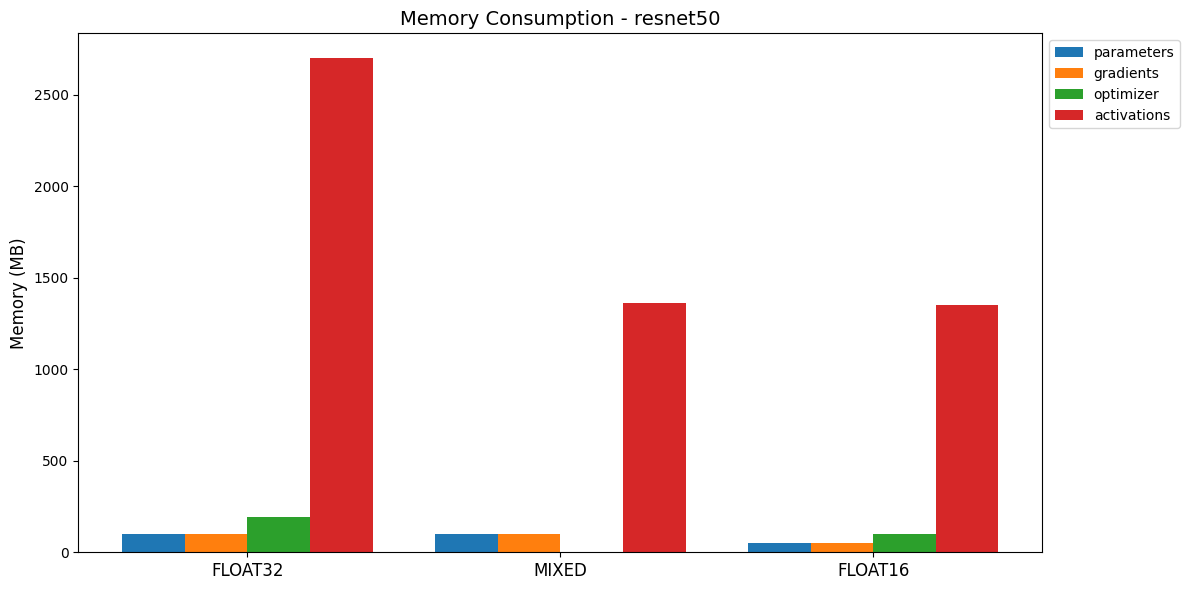


Testing VIT_SMALL

Precision: FLOAT32
Parameters: 43.50 MB
Gradients: 43.50 MB
Optimizer states: 87.01 MB
Activations: 1010.86 MB
TOTAL MEMORY: 1184.87 MB

Precision: MIXED
Parameters: 43.50 MB
Gradients: 43.50 MB
Optimizer states: 87.01 MB
Activations: 613.93 MB
TOTAL MEMORY: 787.94 MB

Precision: FLOAT16
Parameters: 21.75 MB
Gradients: 21.75 MB
Optimizer states: 43.50 MB
Activations: 524.77 MB
TOTAL MEMORY: 611.78 MB


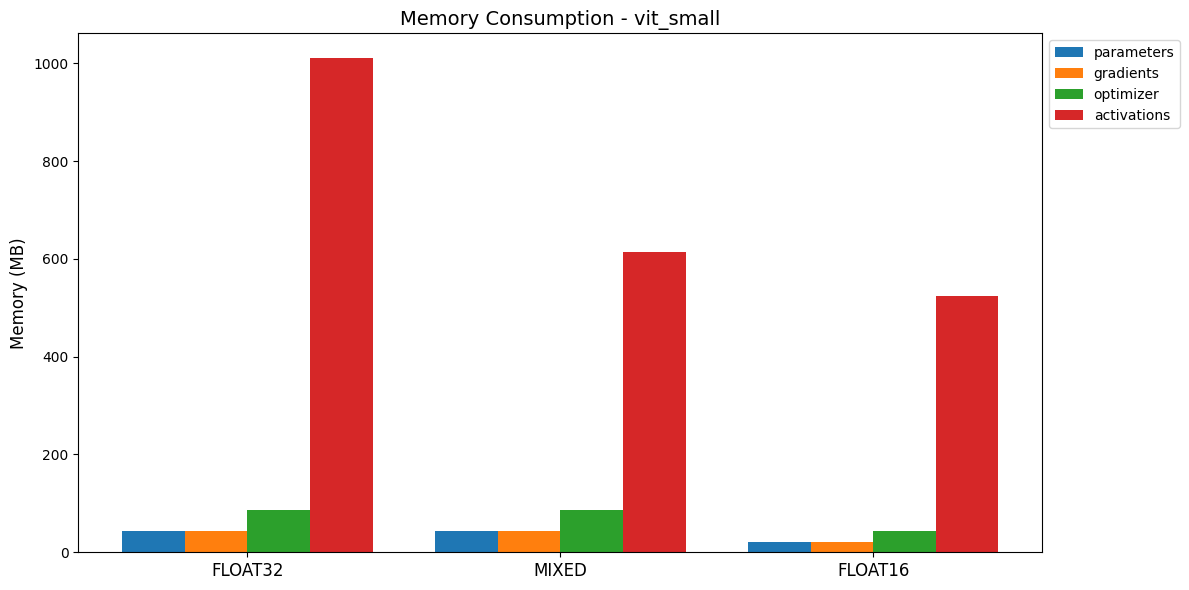



SUMMARY TABLE (Memory in MB)
Model      Precision  Params     Grads      Opt States Activations Total     
resnet50   float32    97.5       97.5       195.0      2701.3     3091.2    
resnet50   mixed      97.5       97.5       0.0        1364.4     1559.4    
resnet50   float16    48.7       48.7       97.5       1349.8     1544.8    
vit_small  float32    43.5       43.5       87.0       1010.9     1184.9    
vit_small  mixed      43.5       43.5       87.0       613.9      787.9     
vit_small  float16    21.8       21.8       43.5       524.8      611.8     


In [ ]:
models_to_test = ['resnet50', 'vit_small']
results = {}

for model_name in models_to_test:
    model_results = {}
    print(f"\n{'='*50}\nTesting {model_name.upper()}\n{'='*50}")
    for precision in ['float32', 'mixed', 'float16']:
        print(f"\nPrecision: {precision.upper()}")
        model_results[precision] = train_and_measure(model_name, precision)

        # Print detailed memory breakdown
        mem_data = model_results[precision]
        total = sum(mem_data.values())
        print(f"Parameters: {mem_data['parameters']:.2f} MB")
        print(f"Gradients: {mem_data['gradients']:.2f} MB")
        print(f"Optimizer states: {mem_data['optimizer']:.2f} MB")
        print(f"Activations: {mem_data['activations']:.2f} MB")
        print(f"TOTAL MEMORY: {total:.2f} MB")

    results[model_name] = model_results
    plot_results(model_results, model_name)

# Print summary table
print("\n\nSUMMARY TABLE (Memory in MB)")
print("{:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
    "Model", "Precision", "Params", "Grads", "Opt States", "Activations", "Total"))

for model_name in models_to_test:
    for precision in ['float32', 'mixed', 'float16']:
        mem = results[model_name][precision]
        total = sum(mem.values())
        print("{:<10} {:<10} {:<10.1f} {:<10.1f} {:<10.1f} {:<10.1f} {:<10.1f}".format(
            model_name,
            precision,
            mem['parameters'],
            mem['gradients'],
            mem['optimizer'],
            mem['activations'],
            total
        ))

# 2. 8-bit Adam vs. 32-bit Adam

## Introduction

The Adam optimizer is highly effective but memory-intensive. For each model parameter (typically FP32), Adam stores two additional FP32 values:
1.  **First Moment (Momentum):** An exponentially decaying average of past gradients.
2.  **Second Moment (Variance):** An exponentially decaying average of past squared gradients.

This means Adam roughly *triples* the memory required compared to storing only the parameters themselves (e.g., for inference or SGD with no momentum). This memory usage can become a bottleneck, preventing the use of larger models or batch sizes.

## 8-bit Adam

To address this, techniques like 8-bit Adam have been developed. The core idea is to store the optimizer states (first and second moments) using only 8 bits per value, drastically reducing their memory footprint (a 4x reduction compared to FP32 states).

This is achieved through **quantization**: representing the FP32 state values using a smaller set of 8-bit values. To maintain performance, 8-bit optimizers often use sophisticated techniques like:
* **Block-wise Quantization:** Quantizing small blocks of the state tensor independently to adapt to varying value ranges.
* **Dynamic Quantization:** Using quantiles or dynamic ranges rather than simple min-max scaling.

We will use the `bitsandbytes` library, which provides a highly optimized implementation of 8-bit Adam (`Adam8bit`).

## Goal

We will train the same model using:
1.  Standard `torch.optim.Adam` (32-bit states).
2.  `bitsandbytes.optim.Adam8bit` (8-bit states).

We will measure the peak GPU memory consumption for both and compare their training loss curves to see the memory savings and assess any potential impact on convergence.

## Prerequisites

In [ ]:
%pip install bitsandbytes torchvision matplotlib numpy torch -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import bitsandbytes as bnb
import random
import numpy as np
import time
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

g = torch.Generator()
g.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 895.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.1 MB/s eta 0:00:00
Device in use: cuda


In [ ]:
# Augmentation + normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

batch_size = 128
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                          drop_last=True, generator=g, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False,
                         drop_last=False, generator=g, num_workers=2)

xb, yb = next(iter(train_loader))
print("Batch size xb (images):", xb.shape)
print("Batch size yb (labels):", yb.shape)

# Model with BatchNorm + Dropout
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # First block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully-connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8*8*64, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.relu3 = nn.ReLU()
        # Dropout
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def train_one_epoch(model, optimizer, loader, loss_fn, device):
    model.train()
    total_loss = 0.0
    start_time = time.time()
    for i, (Xb, yb) in enumerate(loader):
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(Xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    epoch_time = time.time() - start_time
    avg_loss = total_loss / len(loader)
    return avg_loss, epoch_time

def evaluate(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = loss_fn(logits, yb)
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == yb).sum().item()
            total_samples += yb.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = 100.0 * total_correct / total_samples
    return avg_loss, accuracy

100%|██████████| 170M/170M [00:10<00:00, 15.6MB/s]


Batch size xb (images): torch.Size([128, 3, 32, 32])
Batch size yb (labels): torch.Size([128])


## Training

In [ ]:
def train_with_optimizer(optimizer_name, epochs=10, lr=1e-3, wd=0.0):
    print(f"\n=== Training with {optimizer_name} ===")
    model = SimpleCNN(num_classes=10).to(device)

    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats(device)
    start_mem = torch.cuda.memory_allocated(device)
    print(f"Initial GPU memory allocation: {start_mem / 1024**2:.2f} MB")

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {total_params:,}")

    # Select the optimizer
    if optimizer_name == "Adam (32-bit)":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    elif optimizer_name == "Adam (8-bit)":
        optimizer = bnb.optim.Adam8bit(model.parameters(),
                                        lr=lr, weight_decay=wd)
        print("bitsandbytes: Adam8bit is used.")

    loss_fn = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'epoch_time': []}
    total_train_time = 0

    print(f"Starting training for {epochs} epochs...")
    for epoch in range(1, epochs + 1):
        tr_loss, epoch_time = train_one_epoch(model, optimizer,
                                              train_loader, loss_fn, device)
        val_loss, val_acc = evaluate(model, test_loader, loss_fn, device)

        history['train_loss'].append(tr_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['epoch_time'].append(epoch_time)
        total_train_time += epoch_time

        print(f"[Epoch {epoch}/{epochs}] "
              f"Time: {epoch_time:.2f}s | "
              f"Train Loss: {tr_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.2f}%")

    print(f"Total training time: {total_train_time:.2f} s.")

    peak_mem = torch.cuda.max_memory_allocated(device)
    print(f"Peak GPU memory usage: {peak_mem / 1024**2:.2f} MB")
    del model, optimizer, loss_fn
    torch.cuda.empty_cache()

    return peak_mem, history

In [ ]:
peak_mem_32, history_32 = train_with_optimizer(
    "Adam (32-bit)", epochs=10, lr=1e-3, wd=1e-4
)
peak_mem_8, history_8 = train_with_optimizer(
    "Adam (8-bit)",  epochs=10, lr=1e-3, wd=1e-4
)


=== Training with Adam (32-bit) ===
Initial GPU memory allocation: 24.36 MB
Number of trainable parameters: 2,123,402
Starting training for 10 epochs...
[Epoch 1/10] Time: 17.01s | Train Loss: 1.3917 | Val Loss: 1.0909 | Val Acc: 61.23%
[Epoch 2/10] Time: 17.72s | Train Loss: 1.1085 | Val Loss: 0.9038 | Val Acc: 68.53%
[Epoch 3/10] Time: 16.89s | Train Loss: 1.0142 | Val Loss: 0.8326 | Val Acc: 70.92%
[Epoch 4/10] Time: 17.88s | Train Loss: 0.9621 | Val Loss: 0.7935 | Val Acc: 71.99%
[Epoch 5/10] Time: 17.15s | Train Loss: 0.9132 | Val Loss: 0.8132 | Val Acc: 71.58%
[Epoch 6/10] Time: 17.02s | Train Loss: 0.8822 | Val Loss: 0.7466 | Val Acc: 73.92%
[Epoch 7/10] Time: 18.02s | Train Loss: 0.8558 | Val Loss: 0.7053 | Val Acc: 75.31%
[Epoch 8/10] Time: 17.35s | Train Loss: 0.8276 | Val Loss: 0.7165 | Val Acc: 75.16%
[Epoch 9/10] Time: 18.92s | Train Loss: 0.8082 | Val Loss: 0.6851 | Val Acc: 76.34%
[Epoch 10/10] Time: 17.23s | Train Loss: 0.7880 | Val Loss: 0.6709 | Val Acc: 76.84%
Total

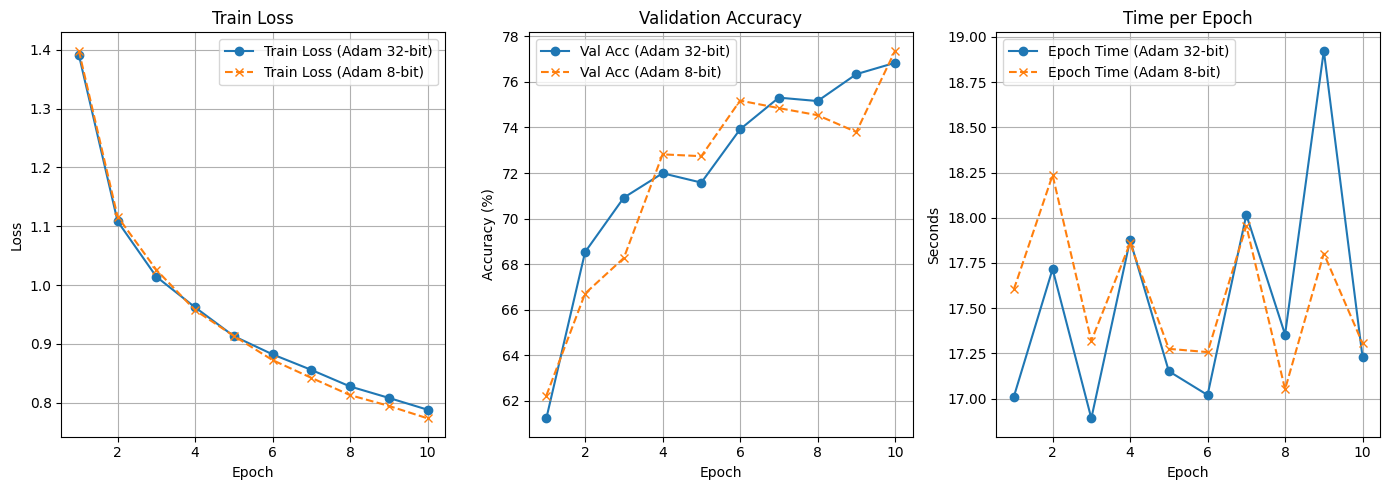

In [ ]:
# Visualization
train_losses_32 = history_32['train_loss']
val_acc_32      = history_32['val_acc']
times_32        = history_32['epoch_time']

train_losses_8  = history_8['train_loss']
val_acc_8       = history_8['val_acc']
times_8         = history_8['epoch_time']

epochs_range = range(1, len(train_losses_32) + 1)

plt.figure(figsize=(14, 5))

# Train Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses_32, label='Train Loss (Adam 32-bit)', marker='o')
plt.plot(epochs_range, train_losses_8, label='Train Loss (Adam 8-bit)', linestyle='--', marker='x')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, val_acc_32, label='Val Acc (Adam 32-bit)', marker='o')
plt.plot(epochs_range, val_acc_8, label='Val Acc (Adam 8-bit)', linestyle='--', marker='x')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Time per Epoch
plt.subplot(1, 3, 3)
plt.plot(epochs_range, times_32, label='Epoch Time (Adam 32-bit)', marker='o')
plt.plot(epochs_range, times_8,  label='Epoch Time (Adam 8-bit)', linestyle='--', marker='x')
plt.title('Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Seconds')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Learning Rate Schedules

## Introduction

The **learning rate (LR)** is a crucial hyperparameter in training neural networks. It determines the step size taken during parameter updates based on the calculated gradients. Choosing a fixed learning rate can be challenging:
* **Too High:** May cause divergence or overshoot the minimum.
* **Too Low:** May lead to very slow convergence or getting stuck in poor local minima.

**Learning Rate Schedules** address this by dynamically adjusting the learning rate during training. The goal is often to start with a relatively high LR to make quick progress early on and then decrease it later to allow for finer adjustments and more stable convergence near a minimum.

## Common LR Schedules in PyTorch

We will explore a few common schedules available in `torch.optim.lr_scheduler`:

1.  **Constant LR (Baseline):** No schedule is used; the learning rate remains fixed throughout training.
2.  **StepLR:** Decreases the learning rate by a factor (`gamma`) every specified number of epochs (`step_size`). Simple and effective, but can cause sudden drops in training progress.
    * `scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)`
3.  **ExponentialLR:** Multiplies the learning rate by a factor (`gamma`) after each epoch. Provides a smoother decay than StepLR.
    * `scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)`
4.  **CosineAnnealingLR:** Smoothly anneals the learning rate from an initial value down to a minimum value (`eta_min`, often 0) over a specified number of epochs (`T_max`), following a cosine curve. It's often restarted (`CosineAnnealingWarmRestarts`). This is a popular and often effective schedule.
    * `scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0)`

## Goal

To train the same model with a fixed (constant) learning rate and compare its loss curve against training runs using StepLR, ExponentialLR, and CosineAnnealingLR. We will visualize both the loss curves and the learning rate changes over time for each schedule.

## Prerequisites

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
# Import LR schedulers
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random

# Seeding
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Ensure that CUDA is available
if not torch.cuda.is_available():
    raise SystemError("CUDA is not available. This code requires a GPU.")
device = torch.device("cuda")
print(f"Using device: {torch.cuda.get_device_name(device)}")

Using device: Tesla T4


In [ ]:
# Loading the actual FashionMNIST dataset
def get_fashion_mnist_loaders(batch_size=128):
    """
    Load the train/test FashionMNIST datasets and create DataLoaders.
    Add minor augmentations (RandomCrop, Flip).
    """
    # Augmentations for training
    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=2),     # a bit of "virtual" padding
        transforms.RandomHorizontalFlip(),         # horizontal flips
        transforms.ToTensor(),
    ])

    # For testing — without any augmentations
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_dataset = torchvision.datasets.FashionMNIST(
        root='./data_fashion', train=True,
        transform=transform_train, download=True
    )
    test_dataset = torchvision.datasets.FashionMNIST(
        root='./data_fashion', train=False,
        transform=transform_test, download=True
    )

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size,
        shuffle=True, num_workers=2, drop_last=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size,
        shuffle=False, num_workers=2, drop_last=False
    )
    return train_loader, test_loader

# Model
def get_model(num_classes=10):
    """
    A simple CNN model with BatchNorm and Dropout.
    Input: (batch_size, 1, 28, 28) for FashionMNIST data.
    """
    class SimpleCNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
            self.bn1   = nn.BatchNorm2d(32)
            self.relu1 = nn.ReLU()
            self.pool1 = nn.MaxPool2d(2, 2)

            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.bn2   = nn.BatchNorm2d(64)
            self.relu2 = nn.ReLU()
            self.pool2 = nn.MaxPool2d(2, 2)

            self.flatten = nn.Flatten()
            self.fc1 = nn.Linear(7 * 7 * 64, 128)
            self.bn3 = nn.BatchNorm1d(128)
            self.relu3 = nn.ReLU()
            self.dropout = nn.Dropout(0.3)
            self.fc2 = nn.Linear(128, num_classes)

        def forward(self, x):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu1(x)
            x = self.pool1(x)

            x = self.conv2(x)
            x = self.bn2(x)
            x = self.relu2(x)
            x = self.pool2(x)

            x = self.flatten(x)
            x = self.fc1(x)
            x = self.bn3(x)
            x = self.relu3(x)
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    return SimpleCNN()

## Training

In [ ]:
# Training function with schedulers
def train_with_scheduler(scheduler_type, initial_lr=1e-3, num_epochs=20,
                         batch_size=128, steps_per_epoch=20):
    """
    Trains a CNN on FashionMNIST with different LR schedulers.
    steps_per_epoch: number of batches to use per epoch (for speed).
    """
    print(f"\n--- Training with {scheduler_type} LR Schedule ---")

    # FashionMNIST data
    train_loader, test_loader = get_fashion_mnist_loaders(batch_size=batch_size)

    # Create model, loss function, and optimizer
    model = get_model(num_classes=10).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)

    # Initialize the scheduler
    scheduler = None
    if scheduler_type == 'Constant':
        pass
    elif scheduler_type == 'StepLR':
        # Reduce LR by a factor of 10 every 5 epochs
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    elif scheduler_type == 'ExponentialLR':
        # Multiply LR by 0.9 each epoch
        scheduler = ExponentialLR(optimizer, gamma=0.9)
    elif scheduler_type == 'CosineAnnealingLR':
        # Cosine annealing function
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

    epoch_losses = []
    learning_rates = []
    start_time = time.time()

    train_iter = iter(train_loader)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss_sum = 0
        for _ in range(steps_per_epoch):
            try:
                data, targets = next(train_iter)
            except StopIteration:
                train_iter = iter(train_loader)
                data, targets = next(train_iter)

            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss_sum += loss.item()

        avg_epoch_loss = epoch_loss_sum / steps_per_epoch
        epoch_losses.append(avg_epoch_loss)

        # Check the current LR before stepping
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        if scheduler is not None:
            scheduler.step()

        # Print loss and LR every few epochs
        if (epoch + 1) % max(1, num_epochs // 5) == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Avg Loss: {avg_epoch_loss:.4f}, LR: {current_lr:.6f}")

    end_time = time.time()
    print(f"Training finished in {end_time - start_time:.2f} seconds.")

    del model, optimizer, loss_fn, data, targets, outputs, loss, scheduler
    torch.cuda.empty_cache()

    return epoch_losses, learning_rates


In [ ]:
# Running training for different schedulers
schedule_results = {}
num_epochs_sched = 20
initial_lr_sched = 1e-3

schedule_types = ['Constant', 'StepLR', 'ExponentialLR', 'CosineAnnealingLR']

for sched_type in schedule_types:
    losses, lrs = train_with_scheduler(
        sched_type,
        initial_lr=initial_lr_sched,
        num_epochs=num_epochs_sched,
        steps_per_epoch=20
    )
    schedule_results[sched_type] = {'losses': losses, 'lrs': lrs}



--- Training with Constant LR Schedule ---


100%|██████████| 26.4M/26.4M [00:01<00:00, 17.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 299kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.59MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 26.0MB/s]


Epoch [4/20], Avg Loss: 0.6242, LR: 0.001000
Epoch [8/20], Avg Loss: 0.5009, LR: 0.001000
Epoch [12/20], Avg Loss: 0.4502, LR: 0.001000
Epoch [16/20], Avg Loss: 0.4208, LR: 0.001000
Epoch [20/20], Avg Loss: 0.4085, LR: 0.001000
Training finished in 10.94 seconds.

--- Training with StepLR LR Schedule ---
Epoch [4/20], Avg Loss: 0.6130, LR: 0.001000
Epoch [8/20], Avg Loss: 0.5108, LR: 0.000100
Epoch [12/20], Avg Loss: 0.4773, LR: 0.000010
Epoch [16/20], Avg Loss: 0.4876, LR: 0.000001
Epoch [20/20], Avg Loss: 0.4968, LR: 0.000001
Training finished in 10.98 seconds.

--- Training with ExponentialLR LR Schedule ---
Epoch [4/20], Avg Loss: 0.6160, LR: 0.000729
Epoch [8/20], Avg Loss: 0.4954, LR: 0.000478
Epoch [12/20], Avg Loss: 0.4440, LR: 0.000314
Epoch [16/20], Avg Loss: 0.4262, LR: 0.000206
Epoch [20/20], Avg Loss: 0.4118, LR: 0.000135
Training finished in 10.91 seconds.

--- Training with CosineAnnealingLR LR Schedule ---
Epoch [4/20], Avg Loss: 0.6120, LR: 0.000946
Epoch [8/20], Avg L

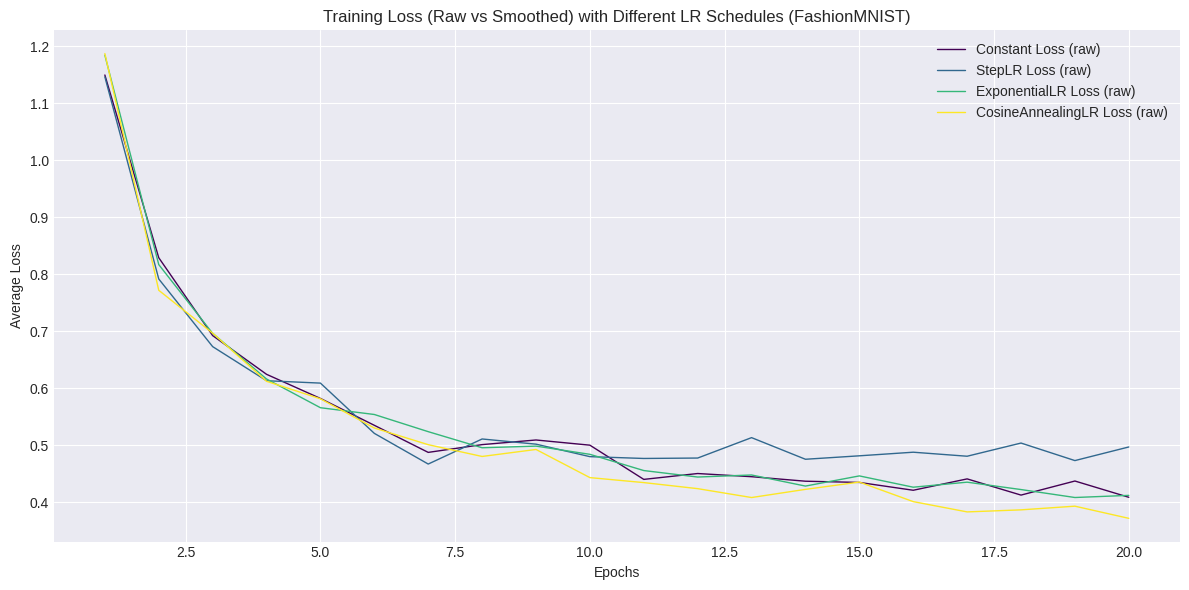

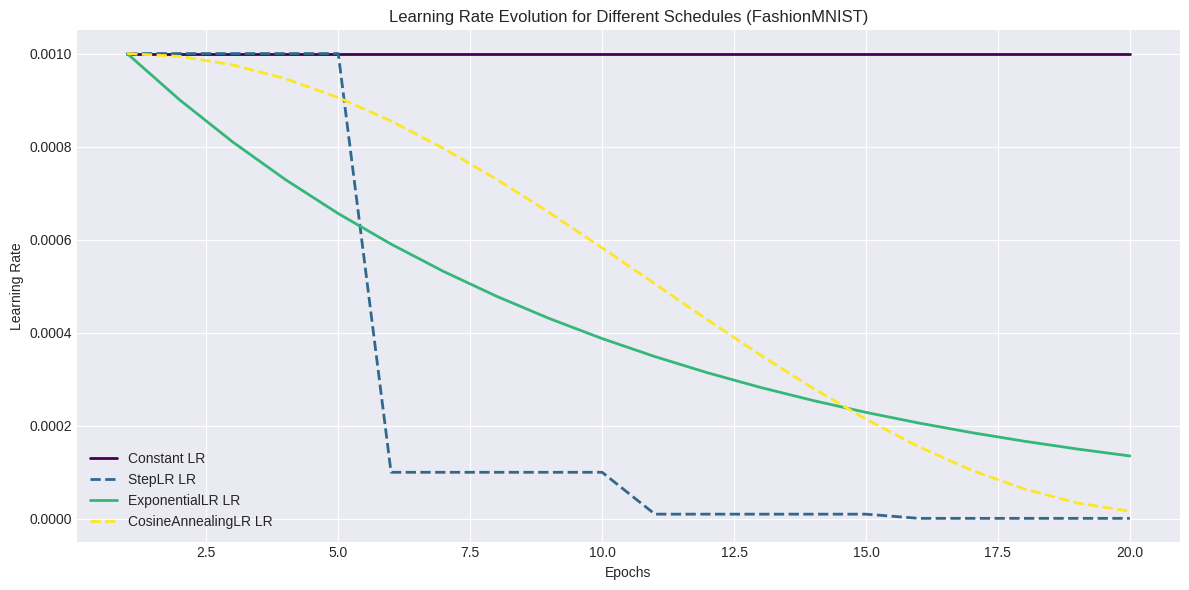

In [ ]:
# Visualization
plt.style.use('seaborn-v0_8-darkgrid')
epochs = range(1, num_epochs_sched + 1)
colors = plt.cm.viridis(np.linspace(0, 1, len(schedule_types)))  # Use a colormap

# Loss Curves Plot
fig_loss_sched, ax_loss_sched = plt.subplots(1, 1, figsize=(12, 6))
for i, sched_type in enumerate(schedule_types):
    if sched_type in schedule_results:
        raw_losses = schedule_results[sched_type]['losses']

        # Plot losses
        ax_loss_sched.plot(epochs, raw_losses,
                           label=f'{sched_type} Loss (raw)',
                           color=colors[i], linewidth=1)

ax_loss_sched.set_xlabel('Epochs')
ax_loss_sched.set_ylabel('Average Loss')
ax_loss_sched.set_title('Training Loss (Raw vs Smoothed) with Different LR Schedules (FashionMNIST)')
ax_loss_sched.legend()
ax_loss_sched.grid(True)
plt.tight_layout()
plt.show()

# Learning Rate Plot
fig_lr, ax_lr = plt.subplots(1, 1, figsize=(12, 6))
for i, sched_type in enumerate(schedule_types):
    if sched_type in schedule_results:
        lrs = schedule_results[sched_type]['lrs']
        ax_lr.plot(epochs, lrs,
                   label=f'{sched_type} LR',
                   color=colors[i], linewidth=2,
                   linestyle='--' if i % 2 else '-')
ax_lr.set_xlabel('Epochs')
ax_lr.set_ylabel('Learning Rate')
ax_lr.set_title('Learning Rate Evolution for Different Schedules (FashionMNIST)')
ax_lr.legend()
ax_lr.grid(True)
plt.tight_layout()
plt.show()

# 4. Training without backpropagation

In the section, we will explore two methods of training with no backpropagation: random search and coordinate desent with approximate derivative.

First, for futrther comparison, let us train a network with simple SGD.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import copy
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.optim import SGD

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

batch_size = 32

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 304kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.66MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.9MB/s]

Training set has 60000 instances
Validation set has 10000 instances


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32) # 784 -> 32
        self.fc2 = nn.Linear(32, 10)     # 32 -> 10

    def forward(self, x):
        x = x.view(x.size(0), -1) # Распрямляем
        x = F.relu(self.fc1(x))   # Первый слой + активация
        x = self.fc2(x)           # Выходной слой
        return x

Pullover  Coat  Coat  Pullover


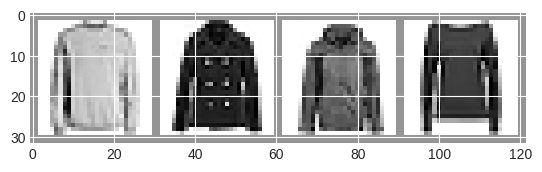

In [ ]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images[:4]
labels = labels[:4]

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
NUM_EPOCHS = 5
CRITERION = nn.CrossEntropyLoss()
LEARNING_RATE = 0.005
N_TRIALS = 10

In [ ]:
def train_model(model, optimizer, train_loader, test_loader, device, update_func=None):
  history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

  for epoch in range(NUM_EPOCHS):
    print (f'EPOCH {epoch+1}/{NUM_EPOCHS}')
    print ('-'*10)

    model.train()
    running_loss = 0.
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f'Training', leave=False):
      inputs = inputs.to(device)
      labels = labels.to(device)

      if update_func is None:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = CRITERION(outputs, labels)
        loss.backward()
        optimizer.step()
      else:
        model = update_func(model, inputs, labels)
        outputs = model(inputs)
        loss = CRITERION(outputs, labels)

      running_loss += loss.item() * inputs.size(0)
      _, predicted = torch.max(outputs, dim=1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

    model.eval()
    test_loss = 0.
    test_correct = 0
    test_total = 0

    with torch.no_grad():
      for inputs, labels in tqdm(test_loader, desc=f'Testing', leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = CRITERION(outputs, labels)

        test_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, dim=1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_epoch_loss = test_loss / test_total
    test_epoch_acc = test_correct / test_total
    history['test_loss'].append(test_epoch_loss)
    history['test_acc'].append(test_epoch_acc)

    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Test Loss: {test_epoch_loss:.4f} Acc: {test_epoch_acc:.4f}')

  return history

In [ ]:
model = Net()
model = model.to(device)
optimizer = SGD(model.parameters(), lr=LEARNING_RATE)
sgd_history = train_model(model, optimizer, train_loader, test_loader, device)

EPOCH 1/5
----------


Train Loss: 1.6771 Acc: 0.4160
Test Loss: 0.7795 Acc: 0.6939
EPOCH 2/5
----------


Train Loss: 0.6662 Acc: 0.7451
Test Loss: 0.6330 Acc: 0.7644
EPOCH 3/5
----------


Train Loss: 0.5737 Acc: 0.7808
Test Loss: 0.5510 Acc: 0.7949
EPOCH 4/5
----------


Train Loss: 0.5222 Acc: 0.8039
Test Loss: 0.5093 Acc: 0.8123
EPOCH 5/5
----------


Train Loss: 0.4866 Acc: 0.8190
Test Loss: 0.5141 Acc: 0.8000


## 2. Random search

In this task, we will update the model parameters in random directions that promote loss decrease.

1. Compute loss $L_0 = f(x, \Theta(t))$
2. Compute randomly shifted loss $L_1 = f(x, \Theta(t) + \Delta)$
3. If $L_1 < L_0$, then update $\Theta(t+1) = \Theta(t) + \Delta$

In [ ]:
def model_random_update(model):
  for p in model.parameters():
    if p.requires_grad:
      p.data = p.data - LEARNING_RATE * torch.empty(p.shape).normal_(mean=0., std=0.1).to(device)
  return model

In [ ]:
def update_random(model, inputs, labels):
  outputs = model(inputs)
  min_loss = CRITERION(outputs, labels)
  cur_weights = copy.deepcopy(model.state_dict())
  min_weights = copy.deepcopy(model.state_dict())
  for j in range(N_TRIALS):
    model = model_random_update(model)
    outputs = model(inputs)
    cur_loss = CRITERION(outputs, labels)
    if cur_loss < min_loss:
      min_loss = cur_loss
      min_weights = copy.deepcopy(model.state_dict())
    model.load_state_dict(cur_weights)
  model.load_state_dict(min_weights)
  return model

In [ ]:
model = Net()
model = model.to(device)
random_history = train_model(model, None, train_loader, test_loader, device, update_random)

EPOCH 1/5
----------


Train Loss: 2.2589 Acc: 0.2498
Test Loss: 2.1605 Acc: 0.3777
EPOCH 2/5
----------


Train Loss: 1.8945 Acc: 0.4066
Test Loss: 1.5723 Acc: 0.5254
EPOCH 3/5
----------


Train Loss: 1.3397 Acc: 0.5506
Test Loss: 1.1738 Acc: 0.5778
EPOCH 4/5
----------


Train Loss: 1.0829 Acc: 0.6248
Test Loss: 1.0294 Acc: 0.6383
EPOCH 5/5
----------


Train Loss: 0.9637 Acc: 0.6568
Test Loss: 0.9507 Acc: 0.6534


## 3. Coordinate Descent with Finite Difference Approximation

For each coordinate in the parameter space, we will compute its approximate derivative via discretization:

$$
\frac{\partial L}{\partial \Theta_i} \approx \frac{f(x, \Theta(t) + \delta e_i) - f(x, \Theta(t))}{\delta}
$$

In [ ]:
def sample_rand_coord(model):
  param_name_size = [(n, p.shape) for n, p in model.named_parameters() if p.requires_grad]
  size_cumsum = np.cumsum([0] + [np.prod(s) for n, s in param_name_size])
  rand_index = np.random.choice(size_cumsum[-1])
  param_index = (size_cumsum <= rand_index).sum() - 1
  coord_index = np.unravel_index(rand_index - size_cumsum[param_index], param_name_size[param_index][1])
  param_name = param_name_size[param_index][0]
  return param_name, coord_index

In [ ]:
def model_random_coord_update(model, value, param_name, coord_index):
  for n, p in model.named_parameters():
    if n == param_name:
      p.data[coord_index] = p.data[coord_index] + value
  return model

In [ ]:
def update_coord_approx(model, inputs, labels):
  for i in range(N_TRIALS):
    outputs = model(inputs)
    cur_loss = CRITERION(outputs, labels).item()
    cur_weights = copy.deepcopy(model.state_dict())
    param_name, coord_index = sample_rand_coord(model)
    model = model_random_coord_update(model, DELTA, param_name, coord_index)
    outputs = model(inputs)
    next_loss = CRITERION(outputs, labels).item()
    partial_approx = (next_loss - cur_loss) / DELTA
    model.load_state_dict(cur_weights)
    model = model_random_coord_update(model, -LEARNING_RATE * partial_approx, param_name, coord_index)
  return model

In [ ]:
DELTA = 1.
N_TRIALS = 10
LEARNING_RATE = 0.1

In [ ]:
model = Net()
model = model.to(device)
random_coord_history = train_model(model, None, train_loader, test_loader, device, update_coord_approx)

EPOCH 1/5
----------


Train Loss: 2.3036 Acc: 0.1142
Test Loss: 2.2849 Acc: 0.1329
EPOCH 2/5
----------


Train Loss: 2.2705 Acc: 0.1316
Test Loss: 2.2531 Acc: 0.1413
EPOCH 3/5
----------


Train Loss: 2.2368 Acc: 0.1377
Test Loss: 2.2160 Acc: 0.1452
EPOCH 4/5
----------


Train Loss: 2.1968 Acc: 0.1716
Test Loss: 2.1705 Acc: 0.2249
EPOCH 5/5
----------


Train Loss: 2.1485 Acc: 0.2583
Test Loss: 2.1192 Acc: 0.3137


Text(0.5, 0, 'Epoch')

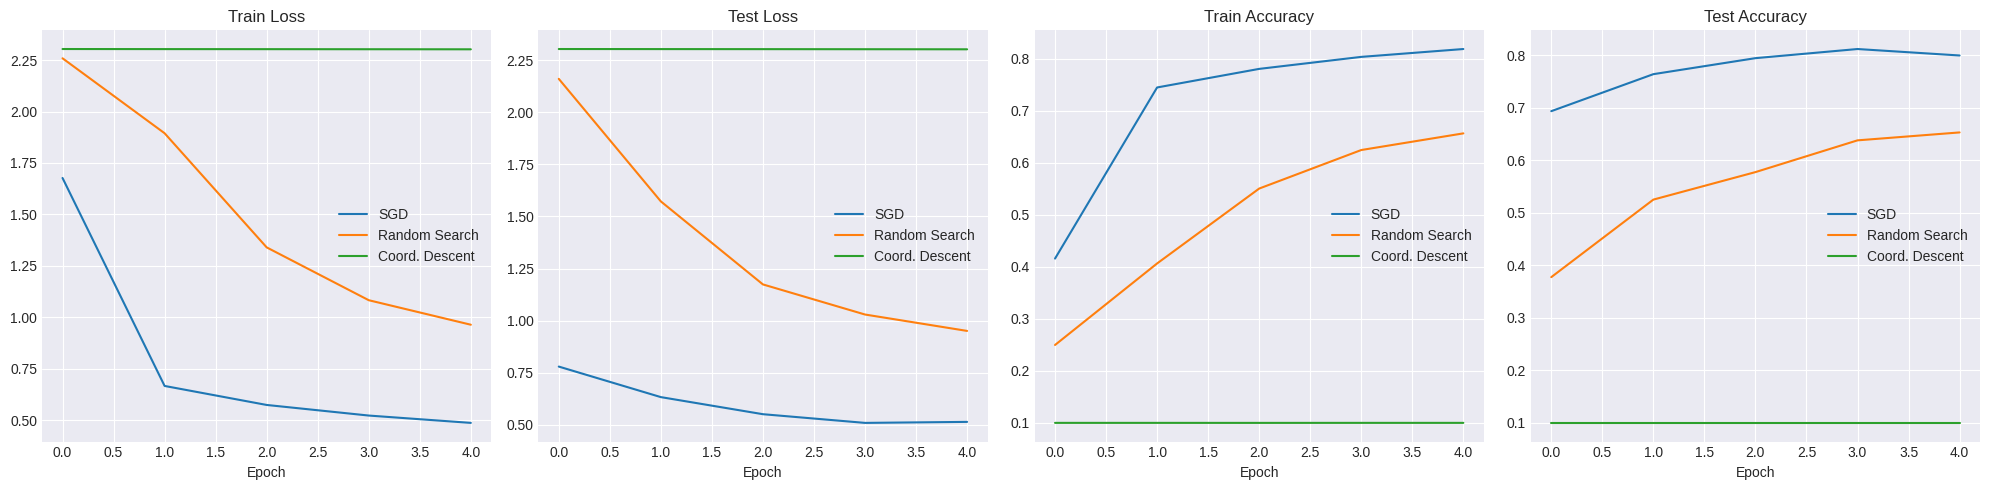

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), tight_layout=True)
ax[0].plot(sgd_history['train_loss'], label='SGD')
ax[0].plot(random_history['train_loss'], label='Random Search')
ax[0].plot(random_coord_history['train_loss'], label='Coord. Descent')
ax[0].legend()
ax[0].set_title('Train Loss')
ax[0].set_xlabel('Epoch')

ax[1].plot(sgd_history['test_loss'], label='SGD')
ax[1].plot(random_history['test_loss'], label='Random Search')
ax[1].plot(random_coord_history['test_loss'], label='Coord. Descent')
ax[1].legend()
ax[1].set_title('Test Loss')
ax[1].set_xlabel('Epoch')

ax[2].plot(sgd_history['train_acc'], label='SGD')
ax[2].plot(random_history['train_acc'], label='Random Search')
ax[2].plot(random_coord_history['train_acc'], label='Coord. Descent')
ax[2].legend()
ax[2].set_title('Train Accuracy')
ax[2].set_xlabel('Epoch')

ax[3].plot(sgd_history['test_acc'], label='SGD')
ax[3].plot(random_history['test_acc'], label='Random Search')
ax[3].plot(random_coord_history['test_acc'], label='Coord. Descent')
ax[3].legend()
ax[3].set_title('Test Accuracy')
ax[3].set_xlabel('Epoch')

**Why Coordinate Descent is So Hard to Train for modern Neural Networks and Its Problems:**

Despite the seeming simplicity of updating parameters one by one, coordinate descent (especially with gradient approximation via finite differences) faces significant challenges when applied to training neural networks:

1.  **High Computational Cost:**
    * To compute the approximation $\frac{\partial L}{\partial \Theta_i}$ using the formula above (forward difference), **one additional forward pass** through the entire model is required to evaluate $f(x, \Theta(t) + \delta e_i)$ for **every single coordinate** $i$ we want to update.
    * If using the more accurate central difference $\frac{f(\Theta + \delta e_i) - f(\Theta - \delta e_i)}{2\delta}$), it requires **two** additional forward passes per coordinate.
    * In neural networks with millions of parameters (coordinates $\Theta_i$), performing this operation repeatedly, even for a random subset of coordinates (`N_TRIALS`), becomes **extremely computationally expensive** compared to backpropagation. Backpropagation calculates **all** exact partial derivatives $\frac{\partial L}{\partial \Theta_i}$ using only **one** forward and **one** backward pass.

2.  **Slow Convergence in High-Dimensional Spaces:**
    * Neural network parameters ($\Theta$) exist in extremely high-dimensional spaces. Coordinate descent attempts to minimize the loss function $L$ by moving along only **one axis** $e_i$ per step.
    * However, neural network parameters are highly interdependent. The optimal direction to decrease the loss is almost never aligned with any single coordinate axis. By restricting updates to single coordinates based on the approximation $\frac{\partial L}{\partial \Theta_i}$, CD takes many small, inefficient steps, effectively "zig-zagging" towards a minimum. This results in **very slow convergence** compared to methods (like SGD, Adam) that move in the direction of the full gradient $\nabla L$.

3.  **Numerical Issues and Noise:**
    * The accuracy of the finite difference approximation $\frac{f(\Theta + \delta e_i) - f(\Theta)}{\delta}$ is highly sensitive to the choice of step size $\delta$. Too large a $\delta$ gives a poor approximation of the derivative. Too small a $\delta$ leads to numerical stability issues: subtracting two very close numbers ($f(\Theta + \delta e_i)$ and $f(\Theta)$) can result in a large relative error (catastrophic cancellation).
    * Since the loss function $f(x, \Theta)$ is typically computed on a **mini-batch** of data $x$, it is itself a **stochastic (noisy)** estimate of the true loss function $L$. Applying finite differences to these already noisy values makes the gradient estimate $\frac{\partial L}{\partial \Theta_i}$ **even noisier and less reliable**.

4.  **Non-Separability and Parameter Correlations:**
    * The loss function $L$ for neural networks is typically highly **non-separable**, meaning the minimum cannot be found by independently minimizing along each coordinate. The parameters are strongly correlated.
    * Coordinate descent implicitly assumes that the function is nearly separable, which is not true for neural networks. Ignoring these strong correlations is another reason for its inefficiency.